In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

In [2]:
segmentations = pd.read_csv("data/airbus-ship-detection/train_ship_segmentations_v2.csv")
segmentations['EncodedPixels'] = segmentations['EncodedPixels'].astype('string')

In [15]:
from tqdm import tqdm


def get_train_image(name: str):
    path = f'data/airbus-ship-detection/train_v2/{name}'
    return cv2.imread(path)


def extract_features_from_image(row: pd.Series) -> pd.Series:
    image = np.zeros((768, 768, 3))  # get_train_image(row['ImageId'])
    row['ImageHeight'], row['ImageWidth'], _ = image.shape
    return row


segmentations = segmentations.apply(lambda x: extract_features_from_image(x), axis=1)

In [16]:
segmentations.head()

,ImageId,EncodedPixels,ImageHeight,ImageWidth
0,00003e153.jpg,<NA>,768,768
1,0001124c7.jpg,<NA>,768,768
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,768,768
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,768,768
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,768,768


In [17]:
def pixels_number(encoded_pixels: str) -> int:
    if pd.isna(encoded_pixels):
        return 0
    return np.array(encoded_pixels.split()[1::2], dtype=int).sum()


segmentations['ShipAreaPercentage'] = segmentations.apply(
    lambda x: pixels_number(x['EncodedPixels']) / (x['ImageHeight'] * x['ImageWidth']) * 100, axis=1)

In [18]:
corrupted_images = ['6384c3e78.jpg']
segmentations[segmentations['ImageId'].isin(corrupted_images)]

,ImageId,EncodedPixels,ImageHeight,ImageWidth,ShipAreaPercentage


In [19]:
segmentations = segmentations.drop(segmentations[segmentations['ImageId'].isin(corrupted_images)].index)
segmentations[segmentations['ImageId'].isin(corrupted_images)]

,ImageId,EncodedPixels,ImageHeight,ImageWidth,ShipAreaPercentage


In [20]:
print(f'There are {segmentations.shape[0]} rows.')
segmentations.head(10)

There are 231722 rows.


,ImageId,EncodedPixels,ImageHeight,ImageWidth,ShipAreaPercentage
0,00003e153.jpg,<NA>,768,768,0.000000
1,0001124c7.jpg,<NA>,768,768,0.000000
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,768,768,0.574409
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,768,768,0.030009
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,768,768,0.025092
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...,768,768,0.081380
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...,768,768,0.001187
7,000194a2d.jpg,254389 9 255157 17 255925 17 256693 17 257461 ...,768,768,0.109863
8,0001b1832.jpg,<NA>,768,768,0.000000
9,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...,768,768,0.067817


In [21]:
train_images_number = segmentations['ImageId'].nunique()
print(f'There are {train_images_number} train images.')

There are 192555 train images.


In [22]:
print(segmentations['ImageHeight'].value_counts())
print(segmentations['ImageWidth'].value_counts())

768    231722
Name: ImageHeight, dtype: int64
768    231722
Name: ImageWidth, dtype: int64


In [23]:
images_without_ships = segmentations['EncodedPixels'].isna().sum()
print(f'There are {images_without_ships} images without ships.')

There are 149999 images without ships.


ShipCount
0            149999
1             27104
2              7674
3              2954
4              1622
5               925
6               657
7               406
8               318
9               243
10              168
11              144
12              124
14               76
13               75
15               66
dtype: int64


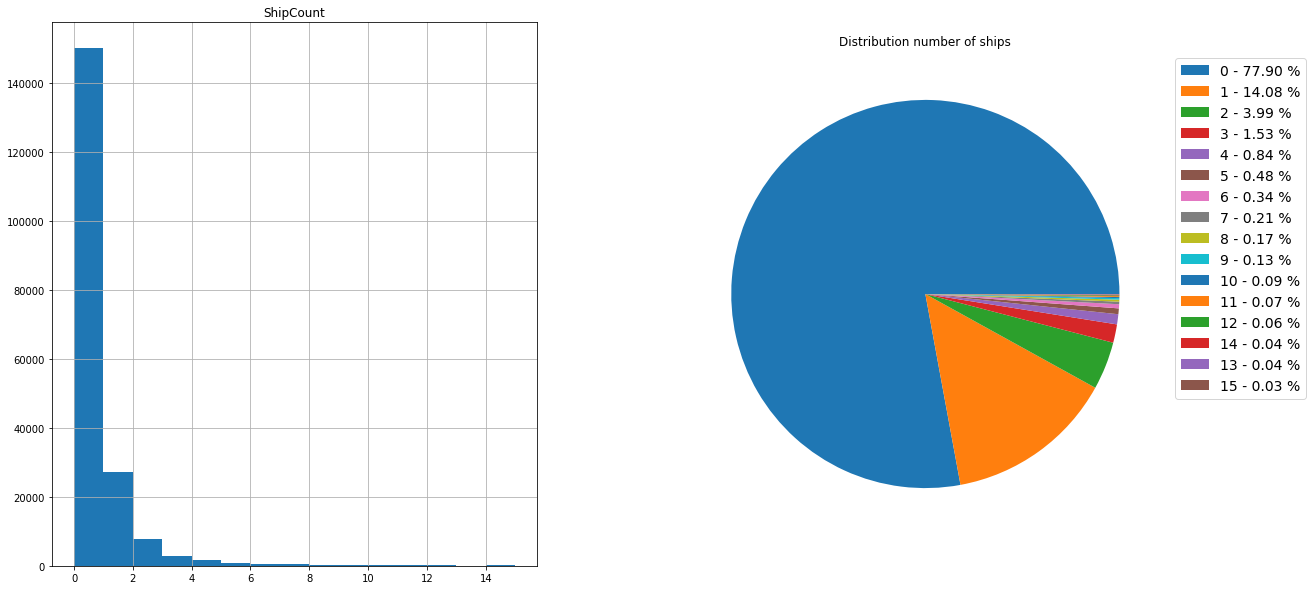

In [24]:
segmentations['ShipCount'] = segmentations.apply(lambda x: 0 if pd.isna(x['EncodedPixels']) else 1, axis=1)
ships_numbers = segmentations[['ImageId', 'ShipCount']].groupby(['ImageId']).sum()
print(ships_numbers.value_counts())

f, ax = plt.subplots(1, 2, figsize=(20, 10))

ships_numbers.hist(bins=15, ax=ax[0])

y = ships_numbers.value_counts().values
percent = 100. * y / y.sum()
labels = ['{0} - {1:1.2f} %'.format(i, j) for i, j in
          zip(ships_numbers.value_counts().index.get_level_values(0), percent)]
ships_numbers.value_counts().plot.pie(labels=None, ax=ax[1])
ax[1].legend(labels, bbox_to_anchor=(1., 1.), fontsize=14)
ax[1].yaxis.set_visible(False)
ax[1].set_title('Distribution number of ships')

plt.show()

Text(0.5, 0, '')

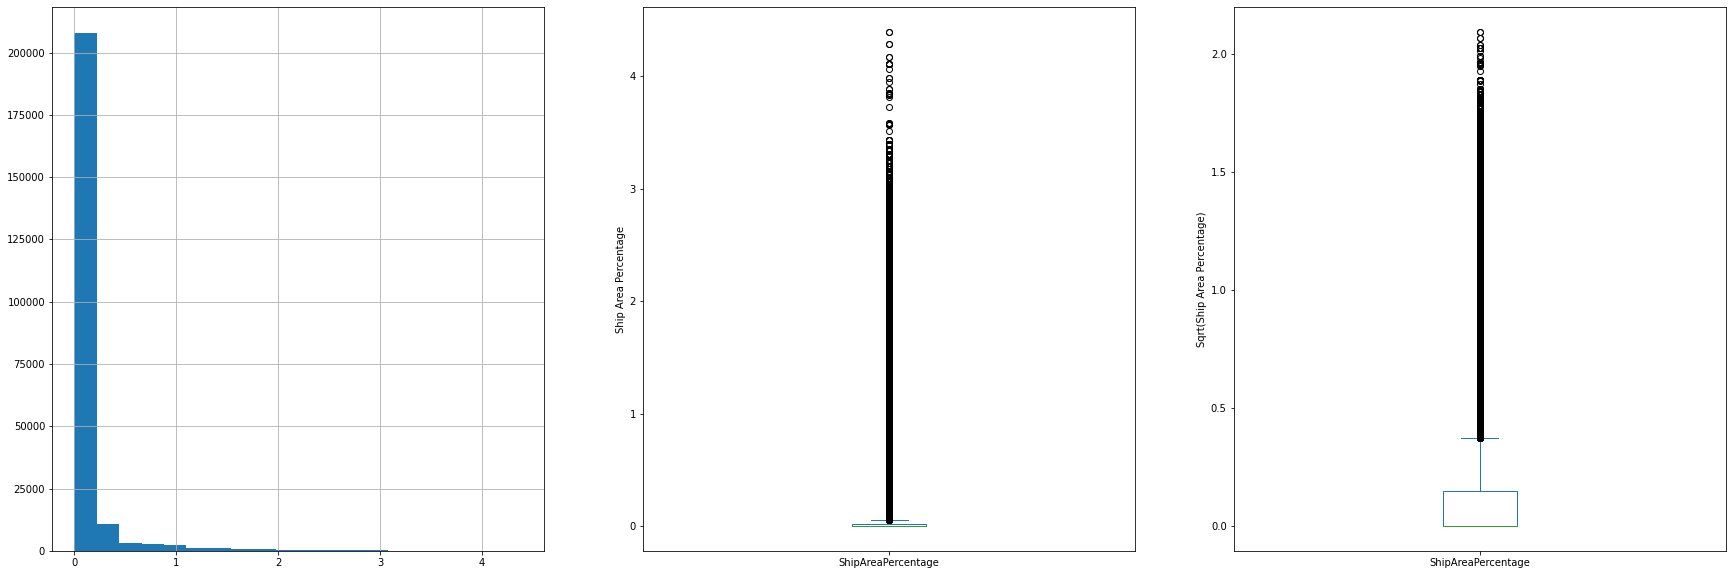

In [25]:
f, ax = plt.subplots(1, 3, figsize=(30, 10))

segmentations['ShipAreaPercentage'].hist(bins=20, ax=ax[0])
segmentations['ShipAreaPercentage'].plot.box(ax=ax[1])
ax[1].set_ylabel('Ship Area Percentage')
ax[1].set_xlabel('')
segmentations['ShipAreaPercentage'].apply(lambda x: x ** 0.5).plot.box(ax=ax[2])
ax[2].set_ylabel('Sqrt(Ship Area Percentage)')
ax[2].set_xlabel('')

In [26]:
def show_image_with_encoded_pixels(image_id: str):
    rows = segmentations[segmentations['ImageId'] == image_id]
    if len(rows) == 0:
        return

    image = get_train_image(image_id)
    image_size, _, _ = image.shape
    ship_count = len(rows)
    all_ships = np.zeros_like(image)

    ax_rows_number = ship_count + 1
    f, ax = plt.subplots(ax_rows_number, 3, figsize=(15, 5 * ax_rows_number))

    for i in range(ship_count):
        image_info = rows.iloc[i]

        encoded_pixels = np.array(image_info['EncodedPixels'].split(), dtype=int)
        pixels, shift = encoded_pixels[::2], encoded_pixels[1::2]
        ship = np.zeros_like(image)

        for pixel, shift in zip(pixels, shift):
            for j in range(shift):
                cur_pixel = pixel + j - 1
                ship[cur_pixel % image_size, cur_pixel // image_size] = [255, 255, 255]
        all_ships += ship

        ax[i, 0].imshow(image)
        ax[i, 1].imshow(ship)
        ax[i, 2].imshow(image * (ship // 255))

    ax[ship_count, 0].imshow(image)
    ax[ship_count, 1].imshow(all_ships)
    ax[ship_count, 2].imshow(image * (all_ships // 255))
    plt.show()

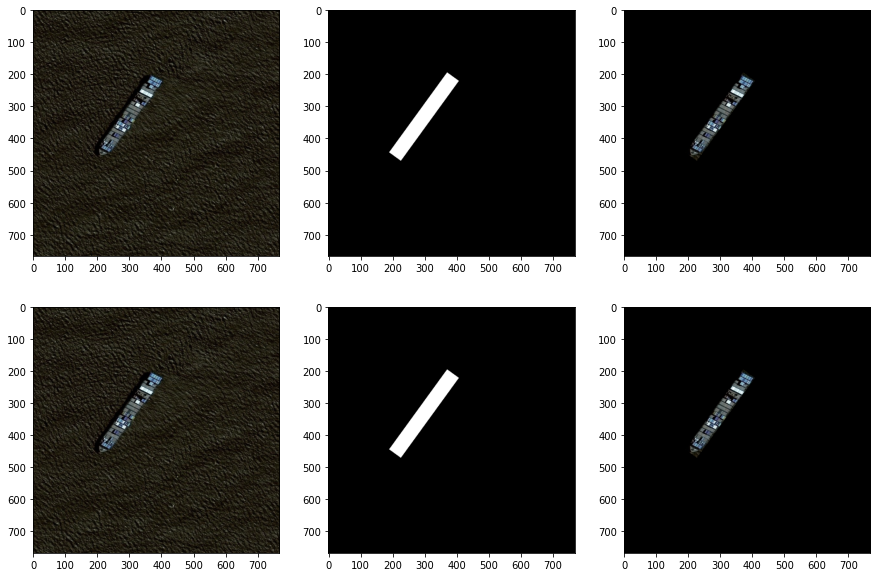

,ImageId,EncodedPixels,ImageHeight,ImageWidth,ShipAreaPercentage,ShipCount
32,0006c52e8.jpg,146366 1 147132 4 147899 5 148666 7 149432 10 ...,768,768,2.355448,1


In [27]:
image_id = '0006c52e8.jpg'
show_image_with_encoded_pixels(image_id)
segmentations[segmentations['ImageId'] == image_id]

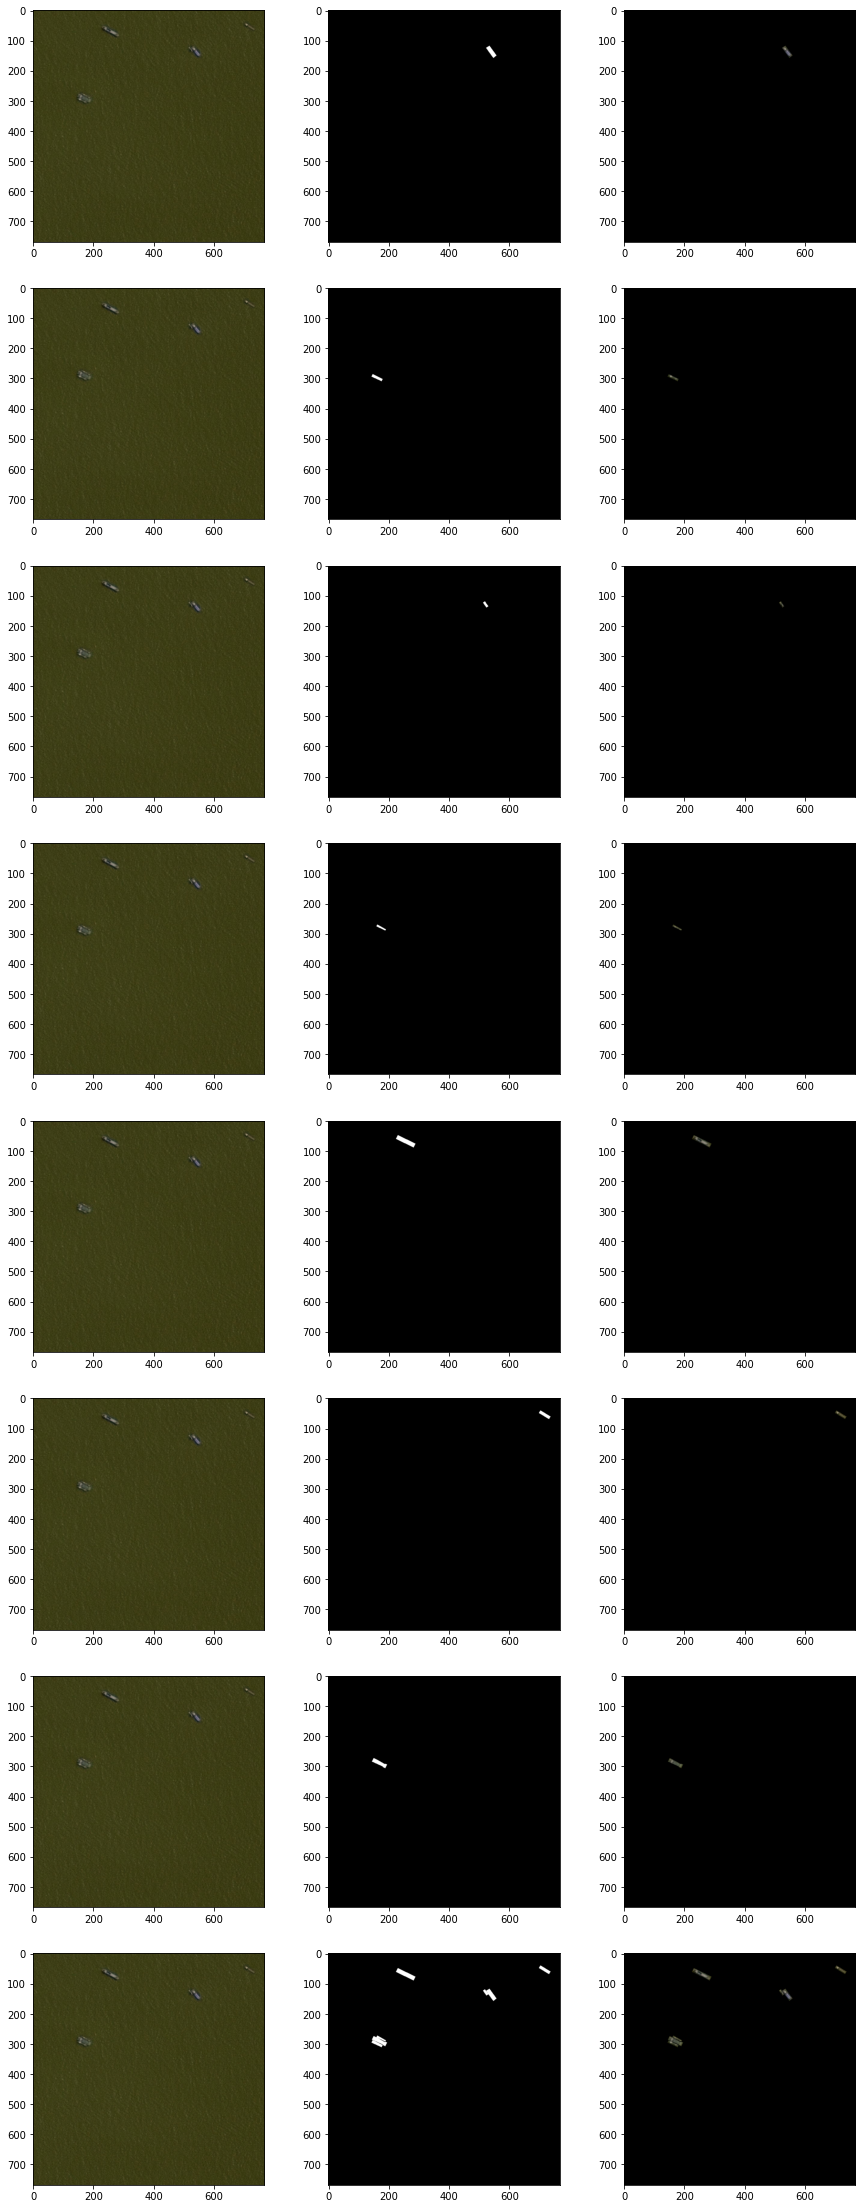

,ImageId,EncodedPixels,ImageHeight,ImageWidth,ShipAreaPercentage,ShipCount
60,00113a75c.jpg,401790 1 402557 3 403325 5 404092 7 404859 9 4...,768,768,0.094774,1
61,00113a75c.jpg,110888 2 111654 4 112420 7 113186 9 113953 11 ...,768,768,0.056458,1
62,00113a75c.jpg,394109 1 394876 4 395644 5 396411 8 397178 10 ...,768,768,0.027296,1
63,00113a75c.jpg,123159 1 123925 4 124691 6 125458 8 126227 7 1...,768,768,0.032383,1
64,00113a75c.jpg,172862 2 173628 4 174394 7 175160 9 175926 12 ...,768,768,0.158522,1
65,00113a75c.jpg,536114 1 536880 4 537646 6 538413 8 539179 10 ...,768,768,0.068834,1
66,00113a75c.jpg,111647 1 112413 3 113179 6 113945 8 114711 10 ...,768,768,0.104099,1


In [28]:
image_id = '00113a75c.jpg'
show_image_with_encoded_pixels(image_id)
segmentations[segmentations['ImageId'] == image_id]

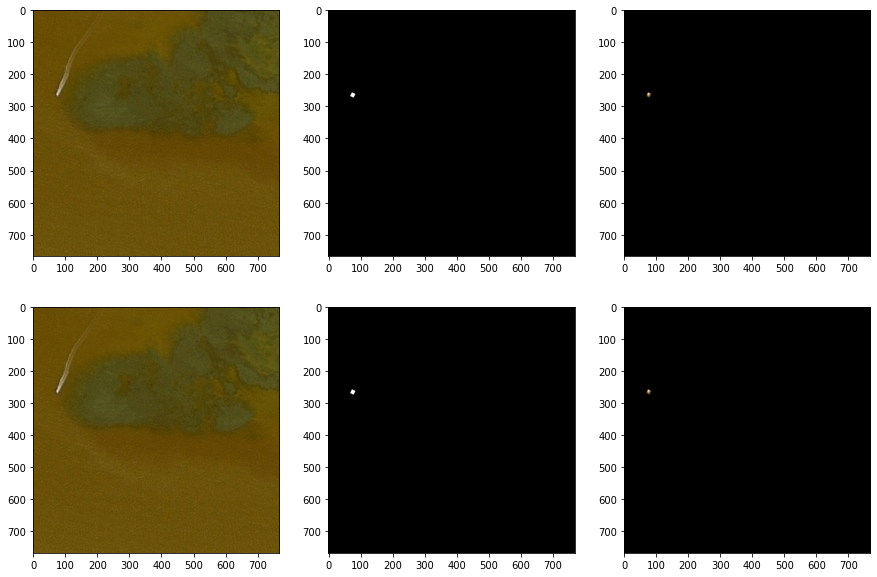

,ImageId,EncodedPixels,ImageHeight,ImageWidth,ShipAreaPercentage,ShipCount
56,000fd9827.jpg,53262 2 54028 4 54794 7 55560 9 56326 12 57092...,768,768,0.026618,1


In [29]:
image_id = '000fd9827.jpg'
show_image_with_encoded_pixels(image_id)
segmentations[segmentations['ImageId'] == image_id]

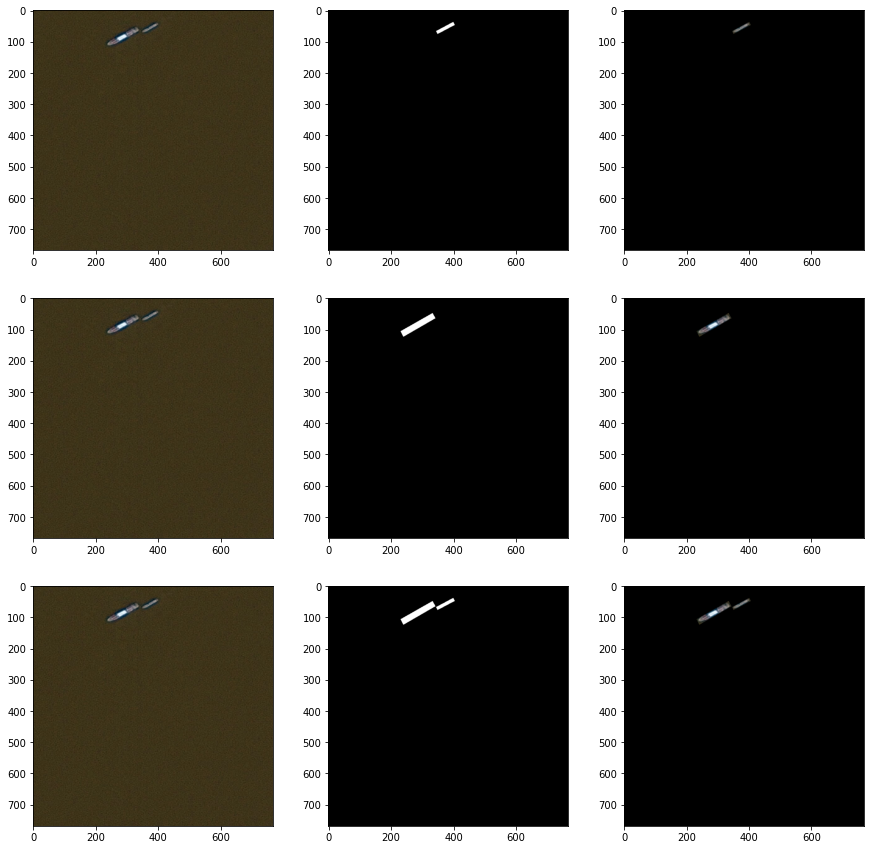

,ImageId,EncodedPixels,ImageHeight,ImageWidth,ShipAreaPercentage,ShipCount
383,007534159.jpg,265796 2 266563 5 267331 7 268098 10 268866 12...,768,768,0.116136,1
384,007534159.jpg,178283 1 179050 4 179818 6 180585 9 181353 11 ...,768,768,0.394864,1


In [30]:
image_id = '007534159.jpg'
show_image_with_encoded_pixels(image_id)
segmentations[segmentations['ImageId'] == image_id]